# Getting Started with CrowdTruth metrics

This tutorial will explain how to use CrowdTruth metrics to process data that was collected with crowdsourcing. For more information about the metrics and how they work, read [this paper](https://arxiv.org/abs/1808.06080).

## Installing the library

First, you will need to install the CrowdTruth Python package.

To get the stable version from PyPi, install the package using ```pip```:

In [ ]:
!pip install crowdtruth

To use the development version, download the source code from the [GitHub repository](https://github.com/CrowdTruth/CrowdTruth-core) and install it frome the console using:

```
python setup.py install
```

Now you can load the CrowdTruth library:

In [1]:
import crowdtruth

## Example crowdsourcing task: Medical Relation Extraction

In this tutorial, we will work with data from a crowdsourcing task on **Medical Relation Extraction**. This is a **multiple choice task** that was executed on [FigureEight](https://www.figure-eight.com/). The workers were asked to read a medical sentence with 2 highlighted terms, then pick from a multiple choice list what are the relations expressed between the 2 terms in the sentence. Below you can see the task template:

<img src="https://raw.githubusercontent.com/CrowdTruth/Medical-Relation-Extraction/master/img/medical_relex.png" alt="Task Template" style="width: 450px; float: left; border:1px solid #d3d3d3; border-radius: 10px; padding: 1px;" />

A sample dataset for this task is available in [this file](https://github.com/CrowdTruth/CrowdTruth-core/blob/master/tutorial/relex_example.csv). containing raw output from the crowd on FigureEight. Download the file and place it in the same folder as this notebook, then check your data:

In [2]:
import pandas as pd

test_data = pd.read_csv("relex_example.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_channel,_worker_id,_country,_region,_city,_ip,...,b2,e1,e2,expdec,rel.type,sent_id,sentence,term1,term2,relations
0,502540300,7/11/2014 23:53:21,1321074821,7/11/2014 23:53:03,neodev,15848372,NaN,NaN,NaN,NaN,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[ASSOCIATED_WITH]
1,502540300,7/12/2014 00:04:01,1321080494,7/12/2014 00:02:53,instagc,25990856,NaN,NaN,NaN,NaN,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[IS_A]
2,502540300,7/12/2014 00:07:10,1321082343,7/12/2014 00:06:34,neodev,25224036,NaN,NaN,NaN,NaN,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[PART_OF]
3,502540300,7/12/2014 00:36:08,1321098346,7/12/2014 00:35:11,instagc,13763729,NaN,NaN,NaN,NaN,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[IS_A]
4,502540300,7/12/2014 00:51:54,1321104806,7/12/2014 00:50:47,clixsense,8888883,NaN,NaN,NaN,NaN,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[SYMPTOM]


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [3]:
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Medical Relation Extraction task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of medical relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [4]:
class TestConfig(DefaultConfig):
    inputColumns = ["term1", "b1", "e1", "term2", "b2", "e2", "sentence"]
    outputColumns = ["relations"]
    
    annotation_separator = " "
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug",
        "location", "side_effect", "contraindicates", "associated_with", "is_a", "part_of",
        "other", "none"]
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [5]:
data, config = crowdtruth.load(
    file = "relex_example.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.relations,output.relations.count,output.relations.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
1321074821,"{u'associated_with': 1, u'causes': 0, u'manife...",1,14,2014-07-11 23:53:21,2014-07-11 23:53:03,15848372,502540300,18,relex_example
1321080494,"{u'is_a': 1, u'causes': 0, u'manifestation': 0...",1,14,2014-07-12 00:04:01,2014-07-12 00:02:53,25990856,502540300,68,relex_example
1321082343,"{u'part_of': 1, u'causes': 0, u'manifestation'...",1,14,2014-07-12 00:07:10,2014-07-12 00:06:34,25224036,502540300,36,relex_example
1321098346,"{u'is_a': 1, u'causes': 0, u'manifestation': 0...",1,14,2014-07-12 00:36:08,2014-07-12 00:35:11,13763729,502540300,57,relex_example
1321104806,"{u'symptom': 1, u'causes': 0, u'manifestation'...",1,14,2014-07-12 00:51:54,2014-07-12 00:50:47,8888883,502540300,67,relex_example


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [6]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for sentences, relations and crowd workers.

The **sentence metrics** are stored in `results["units"]`:

In [7]:
results["units"].head()

,duration,input.b1,input.b2,input.e1,input.e2,input.sentence,input.term1,input.term2,job,output.relations,output.relations.annotations,output.relations.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,
502540300,61.133333,101,3,124,38,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,relex_example,"{u'part_of': 1, u'treats': 0, u'prevents': 0, ...",15,7,15,0.128772,"{u'part_of': 4.36453251319e-05, u'treats': 0.0...",0.123810,"{u'part_of': 0.0666666666667, u'treats': 0.0, ..."
502540301,37.466667,13,62,33,72,Treatment of REFRACTORY DIARRHOEA in AIDS with...,REFRACTORY DIARRHOEA,OCTREOTIDE,relex_example,"{u'part_of': 0, u'treats': 12, u'prevents': 0,...",16,5,15,0.714781,"{u'part_of': 0.0, u'treats': 0.866067315681, u...",0.597887,"{u'part_of': 0.0, u'treats': 0.8, u'prevents':..."
502540302,44.066667,36,36,57,46,These data suggest that subclinical RIBOFLAVIN...,RIBOFLAVIN DEFICIENCY,RIBOFLAVIN,relex_example,"{u'part_of': 1, u'treats': 0, u'prevents': 1, ...",16,9,15,0.140122,"{u'part_of': 4.18662972424e-05, u'treats': 0.0...",0.108707,"{u'part_of': 0.0666666666667, u'treats': 0.0, ..."
502540303,49.466667,145,115,157,123,"Stumpe KO, Haworth D, Hoglund C et al et al. C...",HYPERTENSION,ATENOLOL,relex_example,"{u'part_of': 0, u'treats': 13, u'prevents': 0,...",17,3,15,0.923846,"{u'part_of': 0.0, u'treats': 0.987783242218, u...",0.691013,"{u'part_of': 0.0, u'treats': 0.866666666667, u..."
502540304,57.866667,278,42,285,48,Ninety eight hypothyroid children without GOIT...,THYROID,GOITER,relex_example,"{u'none': 1, u'symptom': 2, u'associated_with'...",16,10,15,0.064941,"{u'none': 0.0939353730937, u'associated_with':...",0.082925,"{u'none': 0.0666666666667, u'associated_with':..."


The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentence. Here we plot its histogram:

Text(0,0.5,'Sentences')

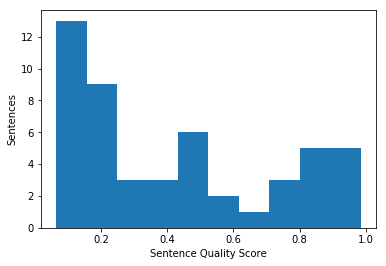

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Sentence Quality Score")
plt.ylabel("Sentences")

The `unit_annotation_score` column in `results["units"]` contains the **sentence-relation scores**. For each sentence, we store a dict of relations

In [14]:
results["units"]["unit_annotation_score"].head()

unit
502540300    {u'part_of': 4.36453251319e-05, u'treats': 0.0...
502540301    {u'part_of': 0.0, u'treats': 0.866067315681, u...
502540302    {u'part_of': 4.18662972424e-05, u'treats': 0.0...
502540303    {u'part_of': 0.0, u'treats': 0.987783242218, u...
502540304    {u'none': 0.0939353730937, u'associated_with':...
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [11]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
5919735,17.566667,1,30,30,0.594206,0.696338,0.853329,0.266201,0.409962,0.649332
6336109,69.000000,1,1,1,0.121084,0.204312,0.592642,0.123718,0.214286,0.577350
6355877,72.800000,1,10,10,0.583606,0.736907,0.791967,0.277754,0.419590,0.661965
6365250,66.133333,1,30,30,0.478141,0.636910,0.750721,0.215944,0.366019,0.589981
7664351,28.950000,1,20,20,0.393457,0.576715,0.682237,0.182027,0.343290,0.530242


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,'Workers')

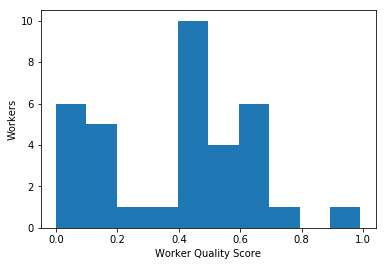

In [12]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

The **relation metrics** are stored in results["annotations"]. The `aqs` column contains the **relation quality scores**, capturing the overall worker agreement over one relation.

In [13]:
results["annotations"]

associated_with             0.257996
causes                      0.705551
contraindicates             0.033856
diagnose_by_test_or_drug    0.464308
is_a                        0.295794
location                    0.096086
manifestation               0.077705
none                        0.136263
other                       0.088374
part_of                     0.081300
prevents                    0.380626
side_effect                 0.017230
symptom                     0.215155
treats                      0.831728
Name: aqs, dtype: float64